<a href="https://colab.research.google.com/github/deepak-ucfknight/Machine_Learning_Spring19/blob/master/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 3**

## **Problem 1 : Feature Extraction using Data Augmentation **

## **Downloading the Cats and Dogs Data**

In [114]:
#cats and dogs image from google
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-04-17 22:52:40--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.197.128, 2607:f8b0:4001:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   202MB/s    in 0.3s    

2019-04-17 22:52:41 (202 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## **Downloading VGG 19 with imagenet weights**

In [0]:
from keras.applications import VGG19

conv_base = VGG19(
    weights='imagenet', 
    include_top=False, 
    input_shape=(224, 224, 3))

In [118]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## **Extracting features from the last layer in Conv_base of VGG19**

In [119]:
conv_base.trainable = False
for layer in conv_base.layers:
  layer.trainable = False
  
last_layer = conv_base.get_layer('block5_pool')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 512)


## **Concatenating a Dense Network on Top of VGG 19**

In [0]:
from keras import layers
from keras import models
from keras import optimizers
from tensorflow.keras import Model


x = layers.Flatten()(last_output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model = models.Model(conv_base.input, x)





## **Freezing VGG19 layer and extracting features for Cats and Dogs Dataset from pre-trained weights**

In [121]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    shuffle=True,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/10
100/100 [==============================] - 36s 360ms/step - loss: 0.5877 - acc: 0.6835 - val_loss: 0.4505 - val_acc: 0.7870
Epoch 2/10
100/100 [==============================] - 32s 322ms/step - loss: 0.4763 - acc: 0.7770 - val_loss: 0.3671 - val_acc: 0.8430
Epoch 3/10
100/100 [==============================] - 33s 330ms/step - loss: 0.4315 - acc: 0.8005 - val_loss: 0.3201 - val_acc: 0.8650
Epoch 4/10
100/100 [==============================] - 32s 321ms/step - loss: 0.4088 - acc: 0.8135 - val_loss: 0.2788 - val_acc: 0.8840
Epoch 5/10
100/100 [==============================] - 34s 340ms/step - loss: 0.3780 - acc: 0.8350 - val_loss: 0.2599 - val_acc: 0.8920
Epoch 6/10
100/100 [==============================] - 32s 321ms/step - loss: 0.3582 - acc: 0.8375 - val_loss: 0.2491 - val_acc: 0.8990
Epoch 7/10
100/100 [==============================] - 32s 321ms/step - loss: 0.3465 - acc: 0.8445 - val_lo

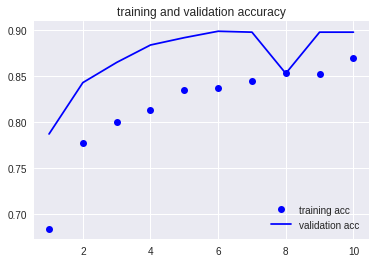

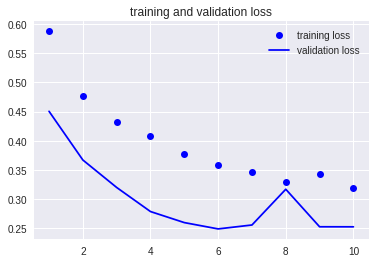

In [122]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## **Problem 2: Fine Tuning VGG19  by re-training the last CONV block in VGG19**

In [124]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False
    


model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])


model.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [125]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    shuffle=True,
    validation_data=validation_generator,
    validation_steps=50
)


Epoch 1/30
100/100 [==============================] - 37s 366ms/step - loss: 0.2972 - acc: 0.8690 - val_loss: 0.2093 - val_acc: 0.9090
Epoch 2/30
100/100 [==============================] - 33s 333ms/step - loss: 0.2413 - acc: 0.9005 - val_loss: 0.1365 - val_acc: 0.9490
Epoch 3/30
100/100 [==============================] - 34s 344ms/step - loss: 0.2066 - acc: 0.9145 - val_loss: 0.1396 - val_acc: 0.9420
Epoch 4/30
100/100 [==============================] - 34s 342ms/step - loss: 0.1740 - acc: 0.9270 - val_loss: 0.1352 - val_acc: 0.9500
Epoch 5/30
100/100 [==============================] - 33s 328ms/step - loss: 0.1691 - acc: 0.9395 - val_loss: 0.1069 - val_acc: 0.9640
Epoch 6/30
100/100 [==============================] - 34s 340ms/step - loss: 0.1558 - acc: 0.9375 - val_loss: 0.1544 - val_acc: 0.9460
Epoch 7/30
100/100 [==============================] - 33s 327ms/step - loss: 0.1337 - acc: 0.9465 - val_loss: 0.1099 - val_acc: 0.9570
Epoch 8/30
100/100 [==============================] - 3

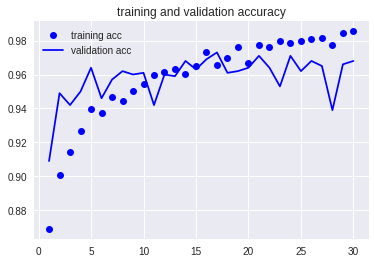

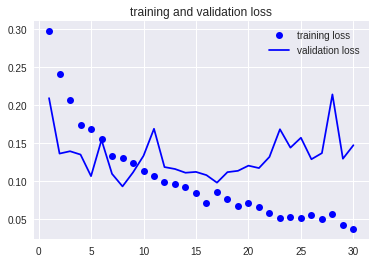

In [126]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

In [0]:
model_fname = 'cats_and_dogs_small_4.h5' 
model.save(model_fname)

## **Problem 3: Visualizing Heat Maps in Model 2**

In [0]:
last_conv_layer = model.get_layer("block5_conv4")

In [0]:
import cv2
from google.colab.patches import cv2_imshow
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from keras import backend as K
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras import utils

In [0]:
def show_superimposed_image(img_path, heatmap):

  img = cv2.imread(img_path)
  # resize the heatmap to be the same size as the original image
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

  heatmap = np.uint8(255 * heatmap)

  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  superimposed_img = heatmap * 0.4 + img

  cv2_imshow(superimposed_img)

In [0]:
def process_image(img_path, idx=0):
  img = image.load_img(img_path, target_size=(224, 224))
  #
  plt.imshow(img)
  plt.grid(None)
  plt.show()
  #
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  #
  preds = model.predict(x)
 
  grads = K.gradients(model.output[:, 0], last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  plt.matshow(heatmap)
  plt.grid(None)
  plt.show()
  show_superimposed_image(img_path, heatmap)

In [132]:
!ls /tmp/cats_and_dogs_filtered/validation/cats | head -3
!ls /tmp/cats_and_dogs_filtered/validation/dogs | head -3

cat.2000.jpg
cat.2001.jpg
cat.2002.jpg
dog.2000.jpg
dog.2001.jpg
dog.2002.jpg


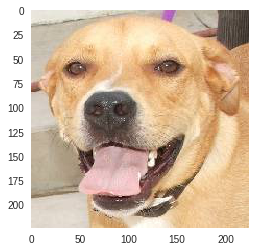

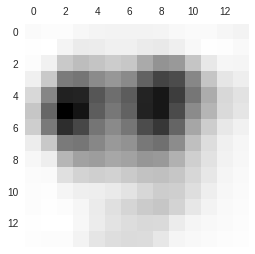

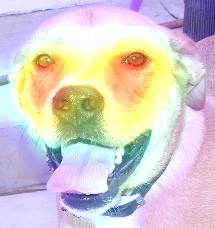

In [133]:
process_image('/tmp/cats_and_dogs_filtered/validation/dogs/dog.2001.jpg')

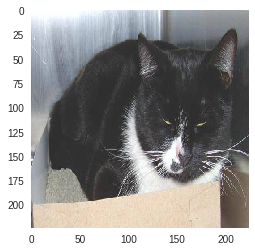

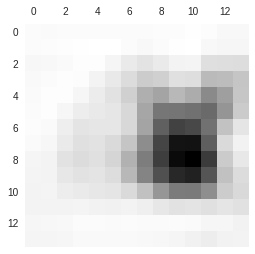

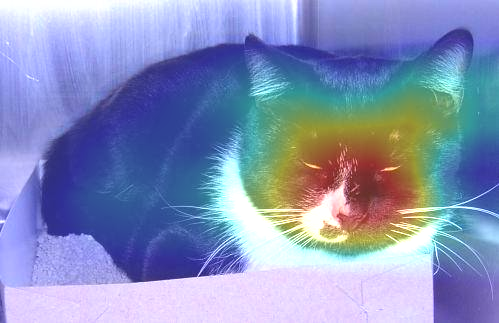

In [134]:
process_image('/tmp/cats_and_dogs_filtered/validation/cats/cat.2001.jpg')

## **Problem 4:  Visualizing Intermediate Activations from the ConvNet layers**

In [135]:
!ls /tmp/cats_and_dogs_filtered/validation/cats | head -3
!ls /tmp/cats_and_dogs_filtered/validation/dogs | head -3

cat.2000.jpg
cat.2001.jpg
cat.2002.jpg
dog.2000.jpg
dog.2001.jpg
dog.2002.jpg


## **We have chosen First Dog Image from the Validation Set for Visualization Purpose**, 
**we can select any Image doesn't matter**

In [0]:

def Create_image_tensor(img_path):
  img = image.load_img(img_path, target_size=(224, 224))
  img_tensor = image.img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis=0)
  img_tensor /= 255.
  return img_tensor

## **Create a Tensor of the Image**

In [0]:
img_path = '/tmp/cats_and_dogs_filtered/validation/dogs/dog.2001.jpg'
dog_2001_tensor = Create_image_tensor(img_path)

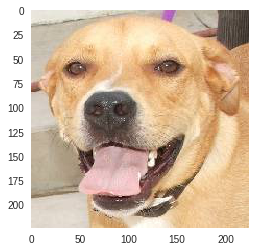

In [138]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.imshow(dog_2001_tensor[0])
plt.grid(None)
plt.show()

In [139]:
model.predict(dog_2001_tensor)

array([[1.]], dtype=float32)

## **Build Activation Model to get intermediate Activations**

In [140]:
from keras import models


layer_outputs = [layer.output for layer in model.layers[1:25]]
activation_model = models.Model(outputs=layer_outputs,input=model.input)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`
  """


In [0]:
activations = activation_model.predict(dog_2001_tensor)

## **Function to Visualize Each Layer of the ConvNet, just pass the layer Index to it**

In [0]:
def visualize_ConvNETs(layerIndex):
  
  layer_name = model.layers[layerIndex].name
  
  images_per_row = 16

  layer_activation = activations[layerIndex-1]
  # the feature map has shape (1, size, size, n_features)
  n_features = activations[layerIndex-1].shape[-1] 
  size = layer_activation.shape[1]
  n_cols = n_features // images_per_row
  display_grid = np.zeros((size * n_cols, images_per_row * size))

  for col in range(n_cols):
    for row in range(images_per_row):
      channel_image = layer_activation[0, :, :, col * images_per_row + row]

      channel_image -= channel_image.mean()
      if(channel_image.std() != 0):
        channel_image /= channel_image.std()
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[
          col * size : (col + 1) * size,
          row * size : (row + 1) * size] = channel_image


  scale = 1. / size
  plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')




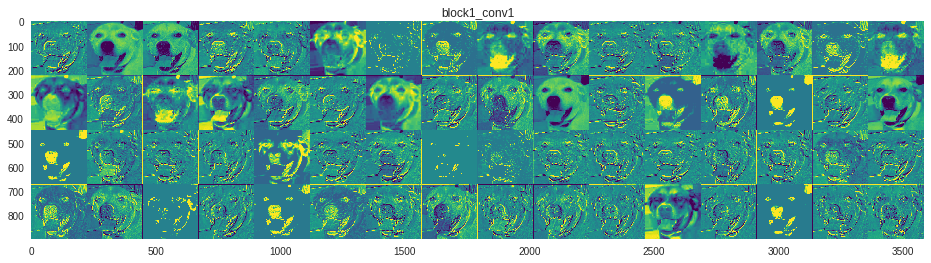

In [143]:
visualize_ConvNETs(1)

## **Visualizing last ConvNet Activation in the Architecture**

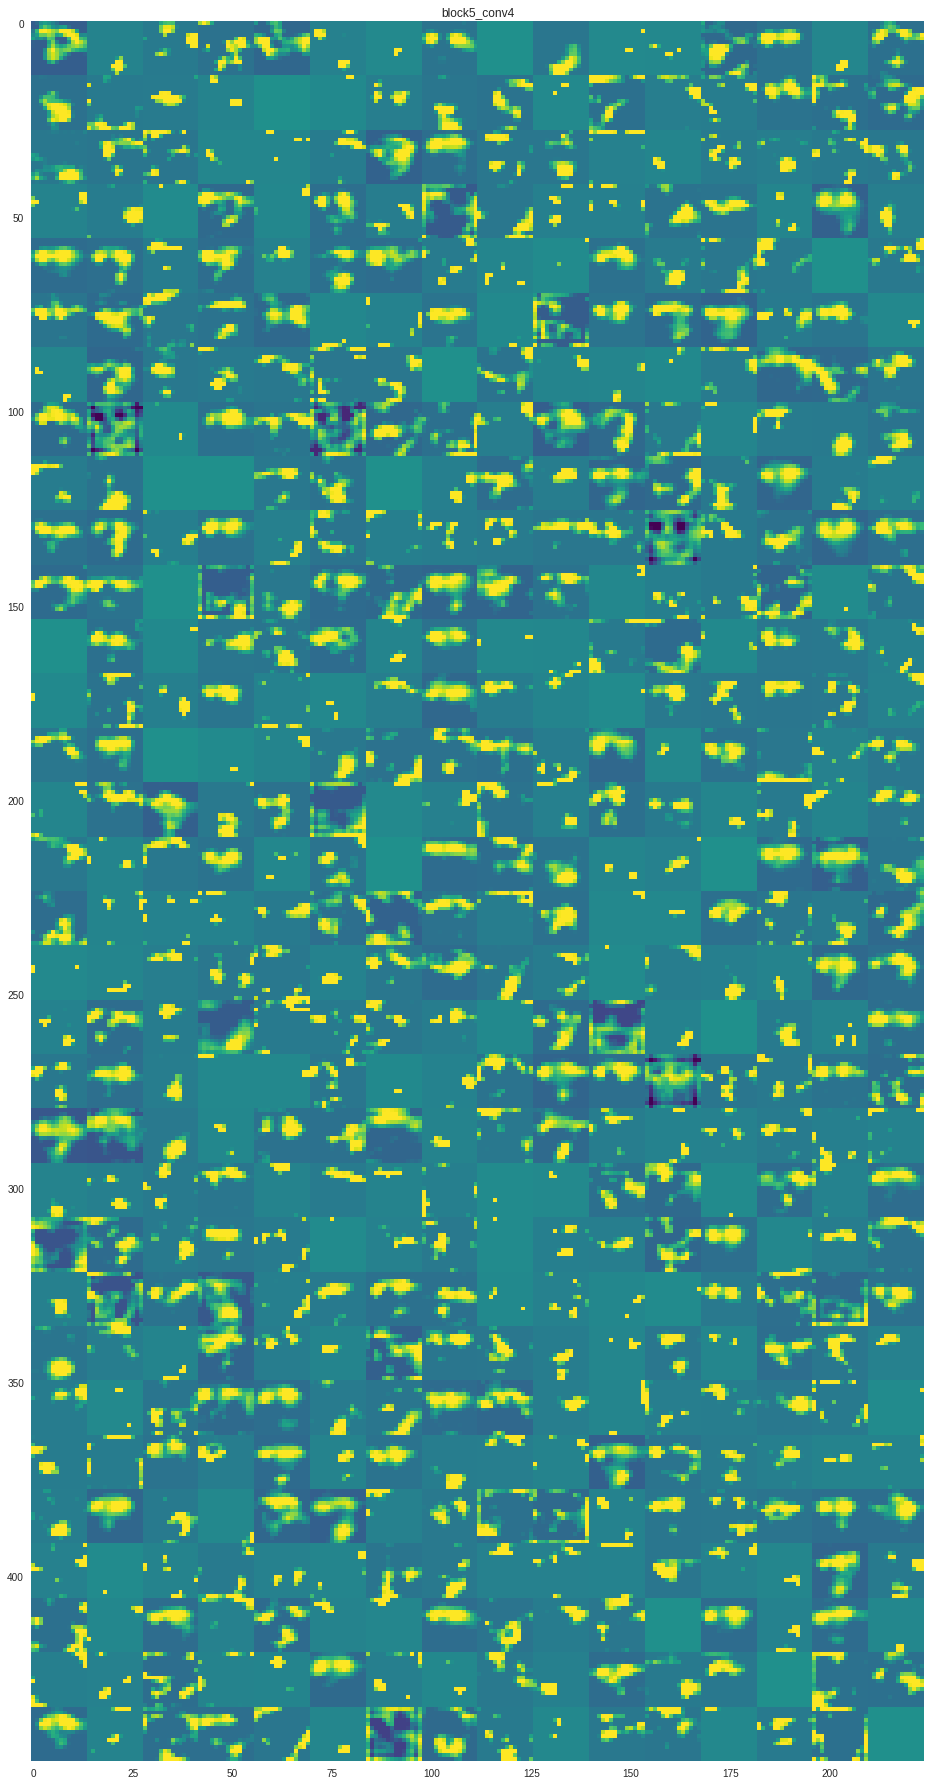

In [144]:
visualize_ConvNETs(20)

## **T-SNE VISUALIZATION**


In [147]:
layer = model.get_layer('dense_5')
layer_output = layer.output
activation_model = models.Model(input=model.input, outputs=[layer_output])
ground_labels = validation_generator.labels
validation_generator.reset()
activations = activation_model.predict_generator(validation_generator,steps=50,verbose=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`
  This is separate from the ipykernel package so we can avoid doing imports until


50/50 [==============================] - 8s 153ms/step


In [0]:
class_names = ["cat", "dog"]

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline
import seaborn as sns

def data_scatter(vecs, labels):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(labels))
    palette = np.array(sns.color_palette("husl", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(12, 12))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(vecs[:, 0], vecs[:, 1], c=palette[labels])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')


    for idx in range(num_classes):

        # Place label at median position of vectors with corresponding label

        x_coord, y_coord = np.median(vecs[labels == idx, :], axis=0)
        txt = ax.text(x_coord, y_coord, class_names[idx], fontsize=16)
        # plot class index black with white contour
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=6, foreground="w"),
            PathEffects.Normal()])

In [149]:
from sklearn.manifold import TSNE
import time
time_start = time.time()

cats_and_dogs_tsne = TSNE(random_state=10).fit_transform(activations)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

t-SNE done! Time elapsed: 5.590991020202637 seconds


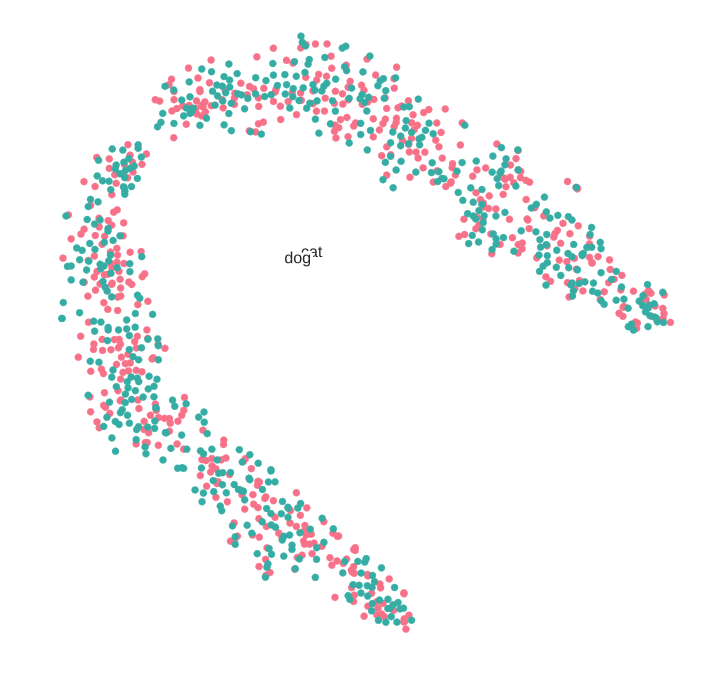

In [150]:
# visualize t-SNE output

data_scatter(cats_and_dogs_tsne, validation_generator.classes)